In [2]:
import s3fs

import os
import json
import time
import pickle
import requests
import traceback
import time
from datetime import datetime
from sklearn import set_config
import warnings
# Ignore warnings from scikit-learn to make this notebook a bit nicer
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

import pandas as pd
from pandas import DataFrame
from pandas import plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import re
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string

import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
import contractions
from contractions import contractions_dict ## pip installed this
from wordcloud import WordCloud, STOPWORDS #pip install
from textblob import TextBlob
!python -m textblob.download_corpora

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
import multiprocessing as mp

import sklearn
from sklearn.utils import resample # Covert too much Rock! to just enough
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':100})
# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.target import ClassBalance
from yellowbrick.target import BalancedBinningReference
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, PrecisionRecallCurve, ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.contrib.classifier import DecisionViz
#from mlxtend.plotting import plot_decision_regions

#Pipeline toolset
# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import Normalizer, RobustScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

#Model toolset
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeClassifier   
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#Evaluation toolset
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_score


import pickle
from joblib import dump, load


[nltk_data] Downloading package brown to /Users/Gretzky/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Gretzky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Gretzky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [3]:
g_df = pd.read_csv('g2_df')
#Drop first, useless column.
g_df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
g_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86290 entries, 0 to 86289
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   genre                   86290 non-null  object 
 1   song_name               86290 non-null  object 
 2   lyrics                  86290 non-null  object 
 3   full_word_count         86290 non-null  int64  
 4   full_character_count    86290 non-null  int64  
 5   full_avg_word_length    86290 non-null  float64
 6   med_lyrics              86290 non-null  object 
 7   med_word_count          86290 non-null  int64  
 8   med_character_count     86290 non-null  int64  
 9   med_avg_word_length     86290 non-null  float64
 10  med_content_affin       86290 non-null  float64
 11  med_sent_label          86290 non-null  object 
 12  med_sent_score          86290 non-null  float64
 13  med_vector              86290 non-null  object 
 14  med_rock_genre_count    86290 non-null

In [4]:
#Decision on what features to include, borne of EDA and visual steering.


df = pd.DataFrame((g_df), columns=['genre','full_word_count','full_character_count',
                                  'med_rock_bool','med_hiphop_bool','med_pop_bool',
                                   'sml_word_count','sml_character_count',
                                   'sml_content_affin','sml_sent_label','sml_vector'])

In [5]:
seed = 99

#Separate majority and minority classes, twice.
majority = df[df.genre=='Rock']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_rock_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

seed = 99

#Separate majority and minority classes, again.
majority = df[df.genre=='Pop']
minority = df[df.genre=='Hip Hop']

# Downsample majority class
majority_pop_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
dfd = pd.concat([majority_rock_downsampled, majority_pop_downsampled, minority])

# Display new class counts
dfd['genre'].value_counts()
# dfd = 'data frame downsampled'

Pop        13560
Hip Hop    13560
Rock       13560
Name: genre, dtype: int64

In [6]:
target = dfd.genre
features = dfd[['full_word_count','full_character_count',
                                  'med_rock_bool','med_hiphop_bool','med_pop_bool',
                                    'sml_word_count','sml_character_count',
                                   'sml_content_affin','sml_sent_label','sml_vector']].copy()

In [7]:
X_train, X_test, y_train, y_test = tts(features, target, test_size = 0.2, random_state=123)
print(df.shape); print(X_train.shape); print(X_test.shape)

(86290, 11)
(32544, 10)
(8136, 10)


In [8]:
# defining the numerical, categorical and textual features
numerical = ['full_word_count','full_character_count','sml_word_count','sml_character_count']
negative_values = ['sml_content_affin','med_rock_bool','med_hiphop_bool','med_pop_bool']
categorical = ['sml_sent_label']
textual = ['sml_vector']

In [9]:
%%time

ct = ColumnTransformer(
    [('num', RobustScaler(), numerical),
     ('neg_values', MinMaxScaler(feature_range=(0,2)), negative_values),
     ('tfidf', TfidfVectorizer(max_features = 6000,
                               stop_words = 'english',
                               ngram_range=(1,1)),
      'sml_vector')
    ], n_jobs=3, verbose=True)

CPU times: user 112 µs, sys: 86 µs, total: 198 µs
Wall time: 204 µs


In [10]:
set_config(display='text')
ct

ColumnTransformer(n_jobs=3,
                  transformers=[('num', RobustScaler(),
                                 ['full_word_count', 'full_character_count',
                                  'sml_word_count', 'sml_character_count']),
                                ('neg_values',
                                 MinMaxScaler(feature_range=(0, 2)),
                                 ['sml_content_affin', 'med_rock_bool',
                                  'med_hiphop_bool', 'med_pop_bool']),
                                ('tfidf',
                                 TfidfVectorizer(max_features=6000,
                                                 stop_words='english'),
                                 'sml_vector')],
                  verbose=True)

In [11]:
%%time
# Creating the feature matrix
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)
print(f'Shape of Term Frequency Matrix of train: {X_train.shape}')
print(f'Shape of Term Frequency Matrix of test: {X_test.shape}')

Shape of Term Frequency Matrix of train: (32544, 6008)
Shape of Term Frequency Matrix of test: (8136, 6008)
CPU times: user 219 ms, sys: 192 ms, total: 411 ms
Wall time: 4.13 s


In [12]:
%%time

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)
print(y_train.shape); print(y_test.shape)

(32544,)
(8136,)
CPU times: user 20.1 ms, sys: 1.81 ms, total: 22 ms
Wall time: 21 ms


In [13]:
classes = Encoder.classes_
classes

array(['Hip Hop', 'Pop', 'Rock'], dtype=object)

In [35]:
%%time
# ExtraTrees classifier
etc = ExtraTreesClassifier(n_estimators=165, criterion='gini',max_depth=350, n_jobs=-1)
# Training the model 
etc.fit(X_train, y_train) 

#Predict the Test using RandomForest classifier
y_pred_etc = etc.predict(X_test)
print('Accuracy on x_train is',etc.score(X_train, y_train))
print('Accuracy on x_test is',etc.score(X_test, y_test))

Accuracy on x_train is 0.9999078171091446
Accuracy on x_test is 0.7764257620452311
CPU times: user 2min 43s, sys: 967 ms, total: 2min 44s
Wall time: 22.7 s


In [15]:
#save
dump(etc, 'etc.joblib')
#load
#etc = load('etc.joblib') 

['etc.joblib']

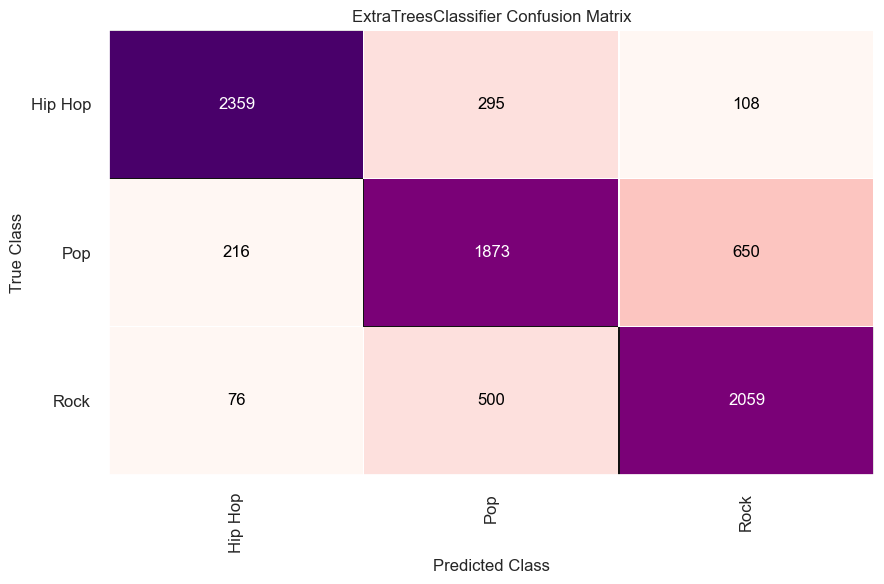

CPU times: user 2.36 s, sys: 114 ms, total: 2.47 s
Wall time: 531 ms


<AxesSubplot:title={'center':'ExtraTreesClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [26]:
%%time

cm_etc = ConfusionMatrix(etc, classes=classes, cmap='RdPu')
cm_etc.fit(X_train, y_train)
cm_etc.score(X_test, y_test)
cm_etc.show()

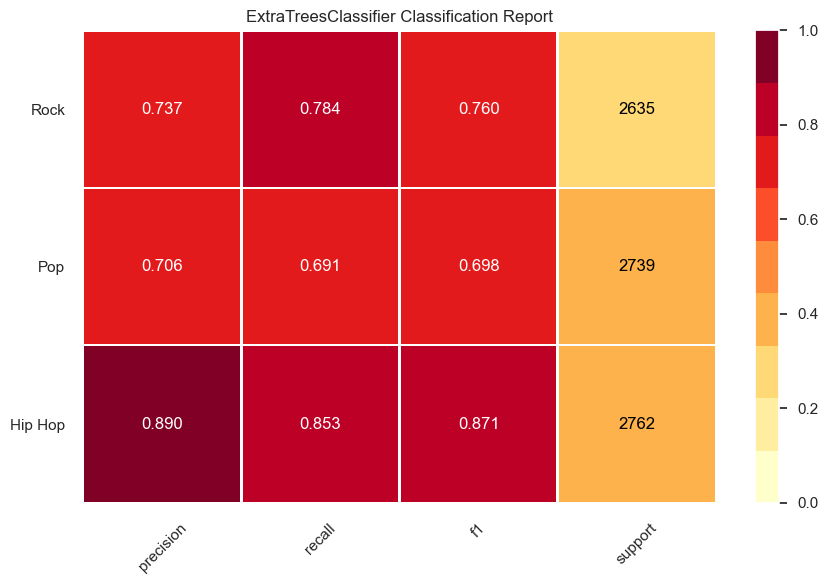

<AxesSubplot:title={'center':'ExtraTreesClassifier Classification Report'}>

In [36]:
cr_etc = ClassificationReport(etc, classes=classes, support=True)
cr_etc.fit(X_train, y_train)
cr_etc.score(X_test, y_test)
cr_etc.show()

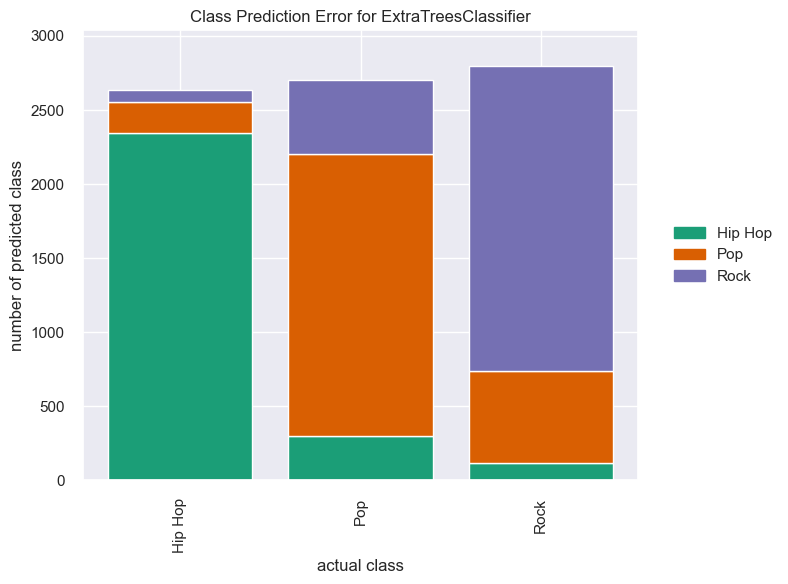

<AxesSubplot:title={'center':'Class Prediction Error for ExtraTreesClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [18]:
cpe_etc = ClassPredictionError(etc, classes=classes)
cpe_etc.fit(X_train, y_train)
cpe_etc.score(X_test, y_test)
cpe_etc.show()

In [24]:
%time
from sklearn.model_selection import GridSearchCV

etc = ExtraTreesClassifier()

# 'bootstrap':[True], 'oob_score':[True, False], 'random_state':[42] .

# Set the parameters by cross-validation
tuned_parameters = [{'bootstrap':[True], 'oob_score':[True, False], 'random_state':[42]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        etc, tuned_parameters, scoring='%s_macro' % score
    )
    
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, classes))
    print()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'bootstrap': True, 'oob_score': True, 'random_state': 42}

Grid scores on development set:

0.774 (+/-0.011) for {'bootstrap': True, 'oob_score': True, 'random_state': 42}
0.774 (+/-0.011) for {'bootstrap': True, 'oob_score': False, 'random_state': 42}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.



YellowbrickTypeError: This estimator is not a classifier; try a regression or clustering score visualizer instead!